# Projecting sea ice decline in the Baltic Sea

In [1]:
import numpy as np
import pandas as pd
import mystyle as ms
import datetime
import matplotlib.pyplot as plt
import xarray as xr

Load in the data:

In [2]:
def reshape_col_month(df, col_name):
    new = pd.DataFrame(columns=['Year', 'Month', col_name])
    yr_arr, mon_arr = [], []
    for yr in df['Year'].values:
        yr_arr  = np.append( yr_arr, np.repeat(yr,12) )
        mon_arr = np.append( mon_arr, np.arange(1,13) )
    new['Year']   = yr_arr.astype(int)
    new['Month']  = mon_arr.astype(int)
    # new[col_name] = np.array(df.drop(columns='Year')).flatten()
    new[col_name] = np.array(df.drop(['Year'], axis=1)).flatten()
    return new

In [3]:
url = '../sea_ice_data/norm.nao.monthly.b5001.current.ascii.table'
nao = pd.read_csv(url, delim_whitespace=True, header=None)
nao.rename(columns = {0: 'Year'}, inplace=True)
nao = reshape_col_month(nao, 'NAO')
nao['Day'] = 15
dt = [ datetime.date( int(row['Year']), int(row['Month']), int(row['Day']) ) for index, row in nao.iterrows() ]
nao['time'] = pd.DatetimeIndex(dt)
nao = nao.drop(columns=['Day'])

url = '../sea_ice_data/nino34.long.anom.data'
nino = pd.read_csv(url, skiprows=1, skipfooter=7, delim_whitespace=True, header=None)
nino.rename(columns = {0: 'Year'}, inplace=True)
nino = reshape_col_month(nino, 'NINO')
nino['Day'] = 15
dt = [ datetime.date( int(row['Year']), int(row['Month']), int(row['Day']) ) for index, row in nino.iterrows() ]
nino['time'] = pd.DatetimeIndex(dt)
nino = nino.drop(columns=['Day'])

url = '../sea_ice_data/ao.data'
ao = pd.read_csv(url, skiprows=1, skipfooter=3, delim_whitespace=True, header=None)
ao.rename(columns = {0: 'Year'}, inplace=True)
ao = reshape_col_month(ao, 'AO')
ao['Day'] = 15
dt = [ datetime.date( int(row['Year']), int(row['Month']), int(row['Day']) ) for index, row in ao.iterrows() ]
ao['time'] = pd.DatetimeIndex(dt)

url = '../sea_ice_data/co2_mm_mlo.txt'
co2 = pd.read_csv(url, skiprows=72, delim_whitespace=True, usecols=[0,1,3], names=['Year','Month','CO2'])
co2['Day'] = 15
dt = [ datetime.date( int(row['Year']), int(row['Month']), int(row['Day']) ) for index, row in co2.iterrows() ]
co2['time'] = pd.DatetimeIndex(dt)

# Merge time series
df = pd.merge(nino,nao)
df = pd.merge(df,ao)
df = pd.merge(df,co2)
df = df.drop(columns=['Day'], axis=0)

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:11: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:20: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.


In [4]:
# Load sea ice data
ds = xr.open_dataset('../sea_ice_data/G10010_SIBT1850_v1.1.nc')
da = ds.seaice_conc
da = da.sel(time=slice('1979-01-01', None)) # take slice over the satellite
# era only (1979-present)

# Select area to work on
da1 = da.isel(latitude=slice(10,95),longitude=slice(65,400))

In [5]:
# Sum ice concentration in area selected
dsum = da1.sum(dim=['latitude','longitude'])

# Generate datetime objects for x-axis
df_all = pd.merge(df,dsum.to_dataframe().reset_index())
X = df_all[['Month','NAO','NINO','AO','CO2']].values
Y = dsum.values
yrs = df_all['Year'].values
dates = np.array([datetime.date(yrs[i],int(X[i,0]),15) for i in range(len(
    yrs))])

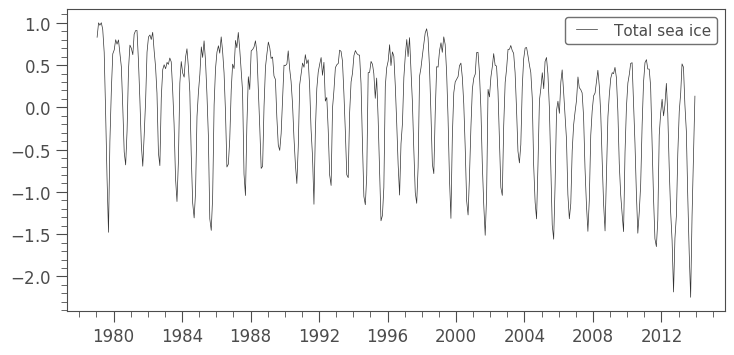

In [7]:
with plt.style.context(ms.ms):
    y_mean = Y - np.mean(Y)
    y = y_mean/max(y_mean)
    plt.plot(dates,y,label='Total sea ice')
    plt.legend()
    plt.show()    

In [17]:
df = pd.DataFrame(columns=['Date','Ice'])

In [19]:
df['Date'] = dates

In [20]:
df['Ice'] = y

In [22]:
df.to_csv('seaice.csv')

In [25]:
type(dates[0])

datetime.date

In [26]:
from astropy.time import Time

In [27]:
d = dates[0]

In [33]:
import datetime

In [41]:
d.day

15

In [43]:
dt = datetime.datetime(d.year, d.month, d.day, 0, 0)

In [48]:
t = Time(dt, format='datetime', scale='utc')

In [51]:
t.jd

2443888.5

In [52]:
jds = np.zeros(len(dates))
for idx, date in enumerate(dates):
    dt = datetime.datetime(date.year, date.month, date.day, 0, 0)
    jds[idx] = Time(dt, format='datetime').jd

In [55]:
df['jd'] = jds

In [56]:
df.to_csv('seaice.csv')